In [ ]:
#| default_exp __init__

In [ ]:
#| export

import warnings
from types import SimpleNamespace
from typing import Union, Optional
from math import nan, sqrt, log, log2, pi, ceil
import cmath
import numpy as np

from mne.utils import logger, verbose
from mne.io.base import BaseRaw
from mne import BaseEpochs

from pathlib import Path
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
from scipy.io import loadmat
from scipy import stats
import mne
from mne.datasets.testing import requires_testing_data

import pyriemann

import pytest

import matplotlib.pyplot as plt
import matplotlib as mpl

## Defnining families of Morlet Wavelets

The following functions facilitate defining families of Morlet Wavelets. This is useful to e.g. plot or analyze properties of the wavelets us ed for feature extraction. These functions are used internally by the feature-computation functions below.

In [ ]:
#| export
def define_frequencies(
        foi_start: float=2, # The lowest frequency of interest.
        foi_end: float=32, # The highest frequency of interest. 
        delta_oct: Union[float, None]=None, #  Controls the frequency resolution. If None, defaults
                                    # to bw_oct / 4. If 1, spacing between frequencies of interesrt will be 1 octave,
                                    # e.g. for foi_start=2 and foi_end=32 foi will be (2, 4, 8, 16, 32).
        bw_oct: float=0.5, # The bandwidth of the Wavelets in octaves. Larger band width lead to more smoothing.
        qt: Union[float, None]=None, # The bandwidth of the Wavelets expressed in characteristic Morlet parameter Q (overriding bw_oct).
        freq_shift_factor: int=1, # Allows shifting the frequency spectrum in logarithmic space (in octave units).
    ) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray): # `foi`, the expaneded frequency range, `sigma_time`, the temporal width (SD), `sigma_freq`, the spectral width. 
    "Construct log-space equidistant frequency bins with proportional variance."
    if bw_oct is not None and qt is not None:
        raise ValueError('Choose bw_oct or qt, not both.')
    elif qt is not None:
        bw_oct = qt2bw(qt)
    elif bw_oct is not None:
        qt = bw2qt(bw_oct)
    else:
        raise ValueError('Please pass bw_oct or qt, at least one of them.')

    assert bw_oct is not None
    
    if delta_oct is None:
        delta_oct = bw_oct / 4.

    foi = 2 ** np.arange(log2(foi_start), log2(foi_end + 1 / 1e5), delta_oct)
    foi *= freq_shift_factor
    foi_min = 2 * foi / (2 ** bw_oct + 1)  # arithmetic mean
    foi_max = 2 * foi / (2 ** -bw_oct + 1)
    # std in freq domain, then in time domain
    sigma_freq = (foi_max - foi_min) / (2 * sqrt(2 * log(2)))
    sigma_time = 1. / (2 * pi * sigma_freq)
    return foi, sigma_time, sigma_freq, bw_oct, qt


def define_wavelets(
        foi: np.ndarray,  # The range of center frequencies.
        sigma_time: np.ndarray, # The temporal width (standard deviations) at a given frequency.
        sfreq: float, # The sampling frequency in Hz.
        kernel_width: int=5, # The width of the kernel in standard deviations, leading to truncation.
        window_shift: float=0.25, # Controls the spacing of the sliding windows proportionally to the
                                  # length (seconds) of the wavelet kernel. Depends on the frequency of
                                   #interest. Values smaller than 1 lead to overlapping sliding windows.
        density: str='oct', # Scaling of the power spectrum in Hz or per octave ('oct'). Defaults to 'oct'.
                            # Note that this scaling is defined at the level of Wavelet kernels, hence,
                            # applies to all derived quantities.
    ) -> list: # The list of complex Morlet wavelets alongside the scaling applied, the effective number of samples and the amount of samples shifted in time, ordered by input frequencies.
    "Compute Morelt Wavelets from frequency-domain parametrization."
    wavelets = list()
    scaling = sqrt(2.0 / sfreq)
    for i_foi in range(len(foi)):
        n_samp_eff = np.int64(np.ceil(kernel_width * sigma_time[i_foi] * sfreq + 1))
        n_shift = np.int64(np.ceil(np.float64(n_samp_eff) * window_shift))
        tt = (np.arange(1, n_samp_eff + 1, 1) - n_samp_eff / 2 - 0.5) / sfreq
        zz = tt / sigma_time[i_foi]
        taper = np.exp(-(1 / 2) * zz ** 2)
        taper /= np.sqrt(np.sum(np.abs(taper) ** 2))
        i_exp = np.exp(1j * 2 * pi * foi[i_foi] * tt)
        kernel = (taper * i_exp)[:, None]
        if density == 'Hz':
            scaling = sqrt(2.0 / sfreq)
        elif density == 'oct':
            scaling = sqrt(2.0 / sfreq) * sqrt(log(2) * foi[i_foi])

        wavelets.append((kernel, scaling, n_samp_eff, n_shift))
    return wavelets

## Computing spectral features from families of Morlet Wavelets.

The following functions provide NumPy and an MNE interfaces for computing spectral features features from M/EEG input signals for a defined family of Morlet wavelets.

The spectral measures implemented include:

### Power measures

- `pow`: power spectral density
- `csd`: cross-spectral density
- `cov`: covariance estimated from wavelet convolutons [@bomatter2023]

### Measures of phase interaction (mixed, coherence type)

- `coh`: coherence [@varela2001brainweb]
- `icoh`: imaginary coherence [@nolte2004identifying]
- `gim`: global interaction measure [@ewald2012estimating]

### More specific measures of phase interaction

- `plv`: phase-locking value [@lachaux1999]
- `pli`: phase-locking index [@stam2007phase]
- `dwpli`: debiased squared weighted phase-lag index [@vinck2011improved]

### Power envelope correlations

- `r_plain`: power envelope correlation (log of rectified wavelet-convoluted timeseries) [@hipp2012large]
- `r_orth`: orthogonalized power envelope correlation [@hipp2012large]

In [ ]:
#| exporti
def _apply_wavlet(data, kernel, scaling, n_samp_eff, n_shift, allow_fraction_nan):
    "Apply Morlet Wavelets to data and handle NaNs."
    n_sens, n_sample = data.shape
    nan_time_idx = np.diff(np.isnan(np.sum(data, axis=0)).astype(int), 
                                    prepend=0)
    idx_up = np.where(nan_time_idx == 1)[0]
    idx_down = np.where(nan_time_idx == -1)[0]
    nan_width_init = np.zeros((data.shape[1]))

    iter_range = list(range(0, data.shape[1] - n_samp_eff + 1, n_shift))
    data_conv = np.empty((n_sens, len(iter_range)), dtype=np.complex128)
    data_conv[:] = np.nan

    # memory allocation
    frac_nan = np.empty((data_conv.shape[1]))
    frac_nan[:] = np.nan

    # handle nans
    nan_width = nan_width_init.copy()
    for i_nan in range(len(idx_up) - 1):
        up, down = idx_up[i_nan], idx_down[i_nan]
        nan_width[up:down] = down - up
    if len(idx_up) > len(idx_down):
        nan_width[idx_up[-1]:-1] = len(nan_width) + 1 - idx_up[-1]

    # convolution
    for cnt, i_section in enumerate(iter_range):
        section = np.float64(data[:, i_section:i_section + n_samp_eff])
        nan_width_section = nan_width[i_section:i_section + n_samp_eff]
        n_nan = np.sum(np.isnan(section[0]))
        frac_nan[cnt] = n_nan / section.shape[1]
        allow_nan_limit = section.shape[1] * allow_fraction_nan
        if n_nan == 0:
            data_conv[:, cnt:cnt + 1] = (
                section @ np.flip(kernel, axis=0) * scaling
            )
        elif ((n_nan < allow_nan_limit) &
                (np.max(nan_width_section) < allow_nan_limit)):
            idx_valid = np.where(~np.isnan(section[0, :]))[0]
            kernel_tmp = np.flip(kernel, axis=0)
            kernel_tmp = (
                kernel_tmp[idx_valid] / 
                np.sqrt(np.sum(np.abs(kernel_tmp[idx_valid]) ** 2))
            )
            # mirror image for convolution operation
            data_conv[:, cnt:cnt + 1] = (
                section[:, idx_valid] @ kernel_tmp * scaling
            )
        else:
            nan_section = np.empty(section.shape[0])
            nan_section[:] = np.nan 
            data_conv[:, cnt] = nan_section

    # derive metrics for frequency-transformed data
    idx_valid = np.where(~np.isnan(data_conv[0, :]))[0]
    n_valid = len(idx_valid)
    data_conv = data_conv[:, idx_valid]
    frac_nan = frac_nan[idx_valid]
    out = None
    if n_valid > 0:
        out = data_conv, n_valid, frac_nan

    return out


def _prepare_output(data, foi, features):
    "Initialize output datastructures."
    n_sens, _ = data.shape
    out = SimpleNamespace()
    info = SimpleNamespace()
    info.n_valid_total = np.empty(len(foi), dtype=np.int64)
    info.foi = foi
    if 'pow' in features:
        out.pow = np.empty((n_sens, len(foi)), dtype = np.float64)
        out.pow_geo = out.pow.copy()
        out.pow_median = out.pow.copy()
        out.pow_var = out.pow.copy()
    if any(k in features for k in ('csd', 'cov', 'cov_oas', 'coh', 'icoh', 'gim')):
        out.csd = np.zeros((n_sens, n_sens, len(foi)), dtype=np.complex128)
    if 'cov' in features or 'cov_oas' in features:
        out.cov = np.zeros((n_sens, n_sens, len(foi)), dtype=np.float64)
    if 'cov_oas' in features:
        out.cov_oas = np.zeros((n_sens, n_sens, len(foi)), dtype=np.float64)
    if 'coh' in features or 'icoh' in features:
        out.coh = np.empty((n_sens, n_sens, len(foi)), dtype=np.complex128)
    if 'icoh' in features:
        out.icoh = np.empty((n_sens, n_sens, len(foi)), dtype=np.float64)
    if 'gim' in features:
        out.gim = np.zeros(len(foi), dtype=np.float64)
    if 'plv' in features:
        out.plv = np.empty((n_sens, n_sens, len(foi)), dtype=np.complex128)
    if 'pli' in features:
        out.pli = np.empty((n_sens, n_sens, len(foi)), dtype=np.float64)
    if 'dwpli' in features:
        out.dwpli = np.zeros((n_sens, n_sens, len(foi)), dtype=np.float64)
    if 'r_plain' in features:
        out.r_plain = np.zeros((n_sens, n_sens, len(foi)), dtype=np.float64)
    if 'r_orth' in features:
        out.r_orth = np.zeros((n_sens, n_sens, len(foi)), dtype=np.float64)
    not_implemented = ()
    for features in features:
        if features in not_implemented:
            raise NotImplementedError(f'{features} is not implemented.')

    return out, info


@verbose
def _compute_spectral_features(data, wavelets, features, out, info,
                               allow_fraction_nan, rank, verbose):
    "Apply wavelet and compute spectral features."
    logger.info(f'Computing convolutions for {len(wavelets)}'
                f' wavelet{"s" if len(wavelets) > 1 else ""}'
                f' and extracting features ...')
    for i_foi, (kernel, scaling, n_samp_eff, n_shift) in enumerate(wavelets):
        data_conv, n_valid, frac_nan = None, None, None
        conv_ = _apply_wavlet(
            data=data, kernel=kernel, n_samp_eff=n_samp_eff,
            n_shift=n_shift, scaling=scaling,
            allow_fraction_nan=allow_fraction_nan)
        if conv_ is not None:
            data_conv, n_valid, frac_nan = conv_
        else:
            logger.warning(f"Found no valid data at {info.foi[i_foi]} Hz.")
            continue

        # power measures
        info.n_valid_total[i_foi] = n_valid
        if 'pow' in features:
            pow = np.abs(data_conv) ** 2
            out.pow[:, i_foi] = np.mean(pow, axis=1)
            out.pow_median[:, i_foi] = np.median(pow, axis=1)
            out.pow_geo[:, i_foi] = np.exp(np.mean(np.log(pow), axis=1))
            out.pow_var[:, i_foi] = np.var(pow, axis=1, ddof=1)

        if any(k in features for k in ('csd', 'cov', 'cov_oas', 'coh', 'icoh', 'gim')):
            out.csd[:, :, i_foi] = data_conv @ data_conv.conj().T  / n_valid

        if 'cov' in features or 'cov_oas' in features:
            out.cov[:, :, i_foi] = np.real(out.csd[:, :, i_foi])

        if 'cov_oas' in features:
            out.cov_oas[:, :, i_foi] = out.cov[:, :, i_foi]
            # The following code is adapted from scikit-learn implementation of
            # Oracle Approximating Shrinkage (OAS) for covariance regularization.
            emp_cov = out.cov_oas[:, :, i_foi]
            n_features = emp_cov.shape[0]
            mu = np.trace(emp_cov) / n_features
            # formula from Chen et al.'s **implementation**
            alpha = np.mean(emp_cov ** 2)
            num = alpha + mu ** 2

            n_samples = n_valid  # use effective number of samples 

            den = (n_samples + 1.0) * (alpha - (mu**2) / n_features)

            shrinkage = 1.0 if den == 0 else min(num / den, 1.0)
            shrunk_cov = (1.0 - shrinkage) * emp_cov
            shrunk_cov.flat[:: n_features + 1] += shrinkage * mu
            out.cov_oas[:, :, i_foi] = shrunk_cov

        # coherence measures
        if 'coh' in features or 'icoh' in features:
            csd = out.csd
            out.coh[:, :, i_foi] = (
                csd[:, :, i_foi] /
                np.sqrt(np.diag(csd[:, :, i_foi])[:, None] @ 
                        np.diag(csd[:, :, i_foi])[None,:])
            )

        if 'icoh' in features:
            out.icoh[:, :, i_foi] = out.coh[:, :, i_foi].imag

        if 'gim' in features:
            C = out.csd[:, :, i_foi]
            if rank < C.shape[0]:
                C_inv = ro_pinv(C.real, rank)
            else:
                C_inv = np.linalg.pinv(C.real)
            out.gim[i_foi] = 1 / 2 * np.trace(
                C_inv @ np.imag(C) @ C_inv @ np.imag(C).T
            )

        # phase measures
        if 'plv' in features:
            data_n = data_conv / np.abs(data_conv)
            out.plv[:, :, i_foi] = data_n @ data_n.conj().T / n_valid

        if 'pli' in features:
            n_sens = data.shape[0]
            data_n = data_conv / np.abs(data_conv)
            for i_idx in range(n_sens):
                for j_idx in range(i_idx + 1, n_sens, 1):
                    out.pli[i_idx, j_idx, i_foi] = np.mean(
                        np.sign(np.imag(data_n[i_idx] * data_n[j_idx].conj()))
                    )
            out.pli[:, :, i_foi] = out.pli[:, :, i_foi] + out.pli[:, :, i_foi].T

        if 'dwpli' in features:
            n_sens = data.shape[0]
            for i_idx in range(n_sens):
                for j_idx in range(i_idx + 1, n_sens, 1):
                    cdi = np.imag(data_conv[i_idx] * np.conj(data_conv[j_idx]))
                    imag_sum = np.sum(cdi)
                    imag_sum_w = np.sum(np.abs(cdi))
                    debias_factor = np.sum(cdi ** 2)
                    out.dwpli[i_idx, j_idx, i_foi]  = (
                        (imag_sum ** 2 - debias_factor) /
                        (imag_sum_w ** 2 - debias_factor)
                    )
            out.dwpli[:, :, i_foi] = out.dwpli[:, :, i_foi] + out.dwpli[:, :, i_foi].T

        # envelope correlation measures
        if any(ft in features for ft in ('r_plain', 'r_orth')):
            for i_sens in range(data.shape[0]):
                seed = data_conv[i_sens]
                seed_logpow = np.log(seed * seed.conj())
                src = data_conv
                src_logpow = np.log(src * src.conj())
                if any('orth' in ft for ft in features):
                    seed_abs = (seed / np.abs(seed))[np.newaxis]
                    src_orth = np.imag(data_conv * np.conj(seed_abs)) * cmath.sqrt(-1) * seed_abs
                    src_logpow_orth = np.log(src_orth * np.conj(src_orth))
                if 'r_plain' in features:
                    r_plain = ro_corrcoef(seed_logpow[np.newaxis], src_logpow, 2)
                    out.r_plain[i_sens, :, i_foi] = r_plain.r.real
                if 'r_orth' in features:
                    r_orth = ro_corrcoef(seed_logpow[np.newaxis], src_logpow_orth, 2)
                    out.r_orth[i_sens, :, i_foi] = r_orth.r.real
                    # make sure we have nans on diag as in Matlab
        else:
            # implement other options here in the future
            pass
    logger.info('done')


def _prepand_nan_epochs(data):
    "Prepends 1 sample of NaN values to every eoch."
    if not data.ndim == 3:
        raise ValueError(f'Data must be 3-dimensional, got {data.ndim} dimensions.')
    nans = [np.nan for _ in range(data.shape[1])]
    data = [np.c_[nans, ep] for ep in data]
    return np.array(data)


def _set_nan_from_annotations_raw(raw, data, annotations):
    "Set nan values to data where bad annotations are present"
    for annot in annotations:
        if annot['description'].lower().startswith('bad'):
            start = annot['onset']
            stop = start + annot['duration']
            start_idx = raw.time_as_index(start, use_rounding=True,
                                          origin=annot['orig_time'])[0]
            stop_idx = raw.time_as_index(stop, use_rounding=True,
                                         origin=annot['orig_time'])[0]
            data[:, start_idx:stop_idx] = np.nan

In [ ]:
#| export
@verbose
def compute_spectral_features_array(
        data: np.ndarray, # The continously sampled input data (may contain NaNs),
                          # shape (n_channels, n_samples))
        sfreq: float, # The sampling frequency in Hz.
        delta_oct: Union[float, None]=None, #  Controls the frequency resolution. If None, defaults
                                    # to bw_oct / 4. If 1, spacing between frequencies of interesrt will be 1 octave,
                                    # e.g. for foi_start=2 and foi_end=32 foi will be (2, 4, 8, 16, 32).
        bw_oct: float=0.5, # The bandwidth of the Wavelets in octaves. Larger band width lead to more smoothing.
        qt: Union[float, None]=None, # The bandwidth of the Wavelets expressed in characteristic Morlet parameter Q (overriding bw_oct).
        foi_start: float=2, # The lowest frequency of interest.
        foi_end: float=32, # The highest frequency of interest. 
        window_shift: float=0.25, # Controls the spacing of the sliding windows proportionally to the
                                  # length (seconds) of the wavelet kernel. Depends on the frequency of
                                   #interest. Values smaller than 1 lead to overlapping sliding windows.
        kernel_width: int=5, # The width of the kernel in standard deviations, leading to truncation.
        freq_shift_factor: int=1, # Allows shifting the frequency spectrum in logarithmic space (in octave units).
        allow_fraction_nan: int=0, # The fraction of NA values allowed.
        features: Union[tuple, list]=('pow',), # The spectral featueres to be computed. 
        density: str='oct', # Scaling of the power spectrum in Hz or per octave ('oct'). Defaults to 'oct'.
                            # Note that this scaling is defined at the level of Wavelet kernels, hence,
                            # applies to all derived quantities.
        rank: Union[int, None]=None, # numeric rank of the input
        verbose: Union[bool, int, str]=False # `mne.verbose` for details. Should only be passed as a keyword argument.
    ) -> (SimpleNamespace, SimpleNamespace): # The `features` with, e.g., `.pow`, `.cov` as attributes
                                             # and `info` outputs with `.foi` and `.n_valid_total` attributes.
    # Compute spectral features from complex Morlet Wavelet transform.

    logger.info('Initializing Wavelets ...')
    foi, sigma_time, *_, bw_oct, qt, = define_frequencies(
        foi_start=foi_start, foi_end=foi_end, delta_oct=delta_oct,
        bw_oct=bw_oct, qt=qt, freq_shift_factor=freq_shift_factor)

    wavelets = define_wavelets(
        foi=foi, sigma_time=sigma_time, kernel_width=kernel_width,
        sfreq=sfreq, window_shift=window_shift, density=density)
    logger.info('done')

    if freq_shift_factor != 1:
        foi /= freq_shift_factor

    out, info = _prepare_output(data, foi=foi, features=features)
    info.bw_oct = bw_oct
    info.qt = qt

    if rank is None:
        rank_ = data.shape[0]
    else:
        rank_ = rank

    _compute_spectral_features(data=data, wavelets=wavelets,
                               features=features, out=out, info=info,
                               allow_fraction_nan=allow_fraction_nan,
                               rank=rank_,
                               verbose=verbose)
    return out, info


@verbose
def compute_spectral_features(
        inst: Union[mne.io.Raw, mne.Epochs], #  An MNE object representing raw (continous) or epoched data.
        delta_oct: Union[float, None]=None, #  Controls the frequency resolution. If None, defaults
                                    # to bw_oct / 4. If 1, spacing between frequencies of interesrt 
                                    # will be 1 octave, e.g. for foi_start=2 and foi_end=32 foi will
                                    # be (2, 4, 8, 16, 32).
        bw_oct: float=0.5, # The bandwidth of the Wavelets in octaves. Larger band width lead to more smoothing.
        qt: Union[float, None]=None, # The bandwidth of the Wavelets expressed in characteristic Morlet parameter Q (overriding bw_oct).
        foi_start: float=2, # The lowest frequency of interest.
        foi_end: float=32, # The highest frequency of interest. 
        window_shift: float=0.25, # Controls the spacing of the sliding windows proportionally to the
                                  # length (seconds) of the wavelet kernel. Depends on the frequency of
                                   #interest. Values smaller than 1 lead to overlapping sliding windows.
        kernel_width: int=5, # The width of the kernel in standard deviations, leading to truncation.
        freq_shift_factor: int=1, # Allows shifting the frequency spectrum in logarithmic space (in octave units).
        allow_fraction_nan: int=0, # The fraction of NA values allowed.
        features: Union[tuple, list]=('pow',), # The spectral featueres to be computed. 
        density: str='oct', # Scaling of the power spectrum in Hz or per octave ('oct'). Defaults to 'oct'.
                            # Note that this scaling is defined at the level of Wavelet kernels, hence,
                            # applies to all derived quantities.
                            # levels of smoothing across frequencies. Requires density set to 'Hz'.
        nan_from_annotations: bool=False, # If annotations should be converted to missing values. Currently only
                                          # supported for raw data. When using epochs, please take care of selecting
                                          # epochs yourself.
        prepend_nan_epochs: bool=False, #  Whether to add a Nan value at the beginning of each epoch to avoid boundary artifacts.
        rank: Union[int, None]=None, # numeric rank of the input
        verbose: Union[bool, int, str]=False # `mne.verbose` for details. Should only be passed as a keyword argument.
    ) -> (SimpleNamespace, SimpleNamespace): # The `features` with, e.g., `.pow`, `.cov` as attributes
                                             # and `info` outputs with `.foi` and `.n_valid_total` attributes.
    # Compute spectral features from complex Morlet Wavelet transform.
    if  not ('eeg' in inst or 'meg' in inst):
        raise ValueError('Currently only supporting EEG or MEG data.')

    if 'eeg' in inst and 'meg' in inst or 'mag' in inst and 'grad' in inst:
        raise ValueError('Currently only supporting unique sensor types at once. '
                         'Please pick your data types.')
   
    out = None
    sfreq = inst.info['sfreq']
    inst_copy_pick = inst.copy().pick(('eeg', 'meg'))
    if isinstance(inst, BaseRaw):
        data = inst_copy_pick.get_data()
    elif isinstance(inst, BaseEpochs):
        data = inst_copy_pick.get_data(copy=False)
    if isinstance(inst, BaseRaw) and nan_from_annotations:
        _set_nan_from_annotations_raw(inst, data, inst.annotations)
    elif isinstance(inst, BaseEpochs) and nan_from_annotations:
        raise ValueError('Converting bad annotations to NaN is only supported '
                         'for continous (raw) data')
    elif isinstance(inst, BaseEpochs):
        if prepend_nan_epochs:
            data = _prepand_nan_epochs(data)
        data = np.hstack(data)  # concatenate epochs

    out, info = compute_spectral_features_array(
        data=data, sfreq=sfreq, bw_oct=bw_oct, qt=qt, delta_oct=delta_oct,
        foi_start=foi_start, foi_end=foi_end, window_shift=window_shift,
        kernel_width=kernel_width, freq_shift_factor=freq_shift_factor,
        allow_fraction_nan=allow_fraction_nan,
        features=features, density=density,
        rank=rank,
        verbose=verbose
    )
    data_unit = ''
    if 'eeg' in inst:
        data_unit = 'V'
    elif 'mag' in inst:
        data_unit = 'T'
    elif 'grad' in inst:
        data_unit = 'T/cm'
    info.unit = f'{data_unit}²/{"Hz" if density == "Hz" else "oct"}'

    return out, info

## Helper functions

To facilitate the integration with the MNE workflow, a simple wrapper can map outputs to the MNE Spectrum class.

In [ ]:
#| export
def spectrum_from_features(
        data: np.ndarray,  # spectral features, e.g. power, shape(n_channels, n_frequencies)
        freqs: np.ndarray, # frequencies, shape(n_frequencies)
        inst_info: mne.Info # the meta data of the MNE instance used for computing the features
    ) -> mne.time_frequency.Spectrum: # the MNE power spectrum object 
    """Create MNE averaged power spectrum object from features"""
    state = dict(
        method='morlet',
        data=data,
        sfreq=inst_info['sfreq'],
        dims=('channel', 'freq'),
        freqs=freqs,
        inst_type_str='Raw',
        data_type='Averaged EEG',
        info=inst_info,
    )
    defaults = dict(
        method=None, fmin=None, fmax=None, tmin=None, tmax=None,
        picks=None, proj=None, reject_by_annotation=None, n_jobs=None,
        verbose=None, remove_dc=None, exclude=None
    )
    return mne.time_frequency.Spectrum(state, **defaults)

Vectorized correlation coefficients.

In [ ]:
#|export
def ro_corrcoef(
        x: np.ndarray, # the seed (assuming time samples on last axis)
        y: np.ndarray, # the targets (assuming time samples on last axis)
        dim: int # number of dimensions
    ) -> SimpleNamespace: # the computed correlation values and statistics:
    # vectorized correlation coefficient and additional statistics.
    ax = dim - 1

    out = SimpleNamespace()
    # check if squeeze is needed
    out.r = ((np.mean(x * y, ax) - x.mean(ax) * y.mean(ax)) / 
             np.sqrt(np.mean(x ** 2, ax) - x.mean(ax) ** 2) /
             np.sqrt(np.mean(y ** 2, ax) - y.mean(ax) ** 2))

    n = x.shape[ax]
    dof = n - 2
    out.t = out.r * np.sqrt(dof / (1 - out.r ** 2))
    out.p = (1 - stats.t.cdf(np.abs(out.t), dof)) * 2
    out.p = np.clip(  # clip p-values to avoid zero-divions errors
        out.p, a_min=np.finfo(out.p.dtype).eps, a_max=None
    )
    out.z = np.sign(out.r) * stats.norm.ppf(1 - out.p / 2, 0, 1)
    out.r_f = out.r @ (1 + (1 - out.r ** 2) / (2 * n))
    out.r_op = out.r @ (1 + (1 - out.r ** 2) / (2 * (n - 3)))
    return out


In [ ]:
from scipy.linalg import svd

In [ ]:
def ro_pinv(
        A: np.ndarray,  # 2d matrix
        r: Union[int, None]=None,  # numeric rank
    ) -> np.ndarray:  # the pseudoinverse of A
    if r is None:
        r = A.shape[0]
    U, s, Vt = svd(A, full_matrices=False)

    s_inv = np.diag(1 / s[:r])

    X = Vt.T[:, :r] @ s_inv @ U[:, :r].T
    return X

A = np.array(
   [[-1.6747, -0.4051, 1.5477],
    [-0.7688, -0.5308, 0.6110],
    [-1.6105, 0.3157, -0.1422]]
)

A_inv = ro_pinv(A)

assert np.allclose(A, ro_pinv(A_inv))
assert np.allclose(A @ A_inv, np.eye(3))
assert np.allclose(A_inv @ A, np.eye(3))
A_inv

array([[ 0.11085518, -0.40693121, -0.54194378],
       [ 1.03227358, -2.57819711,  0.15732342],
       [ 1.03626232, -1.1151485 , -0.54523585]])

In [ ]:
#|export

def bw2qt(
        bw: float, # the Wavelet's bandwidth
    ) -> float:  # characteristic Morlet parameter
    L = sqrt(2 * log(2))
    qt = (
        (2 ** (bw) + 2 ** (-bw) + 2) /
        (2 ** (bw) -2 ** (-bw)) * L
    )
    return qt

assert round(bw2qt(0.5), 1) == 6.9

In [ ]:
#|export

def qt2bw(
        qt: float, # characteristic Morlet parameter
    ) -> float:  # the Wavelet's bandwidth
    L = sqrt(2 * log(2))
    bw = log2(
        sqrt((L ** 2 / (L - qt) ** 2) - 
             ((L + qt) / (L - qt))) - 
        (L / (L - qt))
    )
    return bw

assert round(qt2bw(6.9), 1) == 0.5

### Plot time and frequency domain representations of the Morlet wavelet family.

In [ ]:
#|export

def plot_wavelet_family(
        wavelets: list, # List of wavelets and associated parameters.
        foi: np.ndarray, # Frequencies of interest.
        sampling_rate: float=1e3, #  Wavelet frequency. Inverse of the time separating two points. 
        cmap: mpl.colors.Colormap=plt.cm.viridis, # Colormap.
        f_scale: str="linear", # X-axis scale for the power spectra. 'log' | 'linear'.
        scale: Union[float, int]=4, # Window scaling factor. If <1 the wavelet will be cropped. If >1 wavelet will be padded with 0 leading to a smoother frequency domain representation.
        fmin: Union[float, int]=0, # Min frequency to display.
        fmax: Union[float, int]=120, # Max frequency to display,
    ) -> mpl.figure.Figure:

    fig, axes = plt.subplots(len(wavelets), 2, sharex="col")    
    axes = axes[::-1, :]
    colors = cmap(np.linspace(0.1, 0.9, len(wavelets)))
    for ax in axes[1:].flatten():
        ax.spines[['bottom', 'top', 'left', 'right']].set_visible(False)
        for tick in ax.xaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
    for ax in axes[:1].flatten():
        ax.spines[['top', 'left', 'right']].set_visible(False)

    for i, (w, *_) in enumerate(wavelets):
        axes[i, 0].plot(np.arange(len(w)) - len(w) / 2, w.real, color=colors[i])
        axes[i, 0].plot(
            np.arange(len(w)) - len(w) / 2, w.imag, color=colors[i], ls="--"
        )
        axes[i, 0].set_yticks([])

        w = w.ravel()
        xf = np.fft.fftshift(np.fft.fftfreq(int(len(w) * scale), 1 / sampling_rate))
        yf = np.fft.fftshift(np.fft.fft(w, n=int(len(w) * scale)))
        yf /= np.abs(yf).max()
        mask = (xf > fmin) & (xf < fmax)

        axes[i, 1].plot(xf[mask], np.abs(yf[mask]) ** 2, color=colors[i])
        axes[i, 1].set_yticks([])
        axes[i, 1].set_title(f"{foi[i]:.1f} Hz", y=0.1, x=-.1)

    axes[0, 0].set_xlabel("Time [ms]")
    axes[0, 1].set_xlabel("Frequency [Hz]")
    axes[0, 0].spines["bottom"].set_visible(True)
    axes[0, -1].spines["bottom"].set_visible(True)
    if f_scale == "log":
        axes[0, 1].semilogx(base=2)
        f2 = mpl.ticker.StrMethodFormatter("{x:.0f}")
        axes[0, 1].xaxis.set_major_formatter(f2)
    return axes

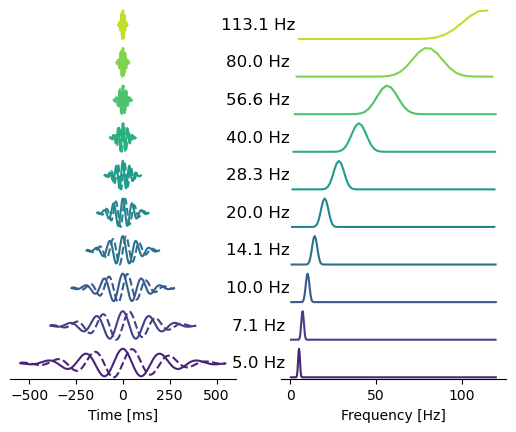

In [ ]:
bw_oct = 0.5
delta_oct = 0.5  # one octave spacing between frequencies of interest (foi)
sampling_rate = 1e3
foi, sigma_time, sigma_freq, *_ = define_frequencies(
    foi_start=5, foi_end=120, delta_oct=delta_oct, bw_oct=bw_oct
)
wavelets = define_wavelets(
    foi,
    sigma_time,
    sfreq=sampling_rate
)
plot_wavelet_family(wavelets, foi)
plt.show()

This helper computes correlation coefficients and related statistics, including hypothesis tests from input vectors or matricess. The correlations are between either the input vector `x` and vector `y` or all columns of `y` or between each column of `x` and the corresponding colymn in `y` with the same index.

In [ ]:
rng = np.random.RandomState(42)
x = rng.random_sample((100, 1)).T 
y = rng.random_sample((100, 3)).T
out = ro_corrcoef(x, y, 2)
print(out.r)  # correlation between pairs of columns in x and y
print(out.p)  # associated p values

[-0.14794559  0.10328645  0.03207745]
[0.14184577 0.30648903 0.75137784]


## More unit tests and validation

The tests below establish equivalence up to a given decimal with the original Matlab code.

In [ ]:
def read_testing_data():
    raw = mne.io.read_raw(
        mne.datasets.testing.data_path() / 'MEG/sample/sample_audvis_trunc_raw.fif'
    )
    raw.pick('eeg')
    raw.drop_channels('EEG 053')
    raw.load_data()
    return raw

def get_matlab_results():
    testing_path =  Path().cwd() / 'data'
    matlab_results = loadmat(
        testing_path / 'mne_meeglet_testing_data.mat', squeeze_me=True
    )
    mat_results = [
        matlab_results[f'out{kk}'] for kk in (1, 2, 3)
    ]
    return mat_results, matlab_results

In [ ]:
if False:  # testing & exploring testing data
    raw = read_testing_data()
    plt.figure(figsize=(10, 6))
    plt.plot(raw.times, read_testing_data().get_data().T * 1e6);
    plt.ylabel(f'EEG $\mu V$')
    plt.xlabel('Time [s]')
    plt.xlim(0, raw.times[-1]);
    plt.ylim(-100, 200);

In [ ]:
def test_compare_matlab_vs_python():
    "Test spectral features array-interface against Matlab implementation."
    
    raw = read_testing_data()
    
    dat = raw.get_data() * 1e6
    dat[:, 4999:5050] = np.nan
    
    sfreq = raw.info['sfreq']
    print(
        dat.shape,
        sfreq
    )
        
    mat_results, matlab_results = get_matlab_results()
        
    features = [
        'pow', 'pow_geo', 'pow_median', 'pow_var', 'csd', 'cov', 'gim',
        'coh', 'icoh', 'plv', 'pli', 'dwpli', 'r_plain', 'r_orth'
    ]
    
    cfg1 = dict(
        data=dat,
        sfreq=sfreq,
        bw_oct=0.5,
        foi_start=2,
        foi_end=32,
        window_shift=0.25,
        kernel_width=5,
        allow_fraction_nan=0,
        freq_shift_factor=1,
        features=features,
        density='oct'
    )
    cfg2 = dict(cfg1)
    cfg2['density'] = 'Hz'
    cfg2['bw_oct'] = None
    cfg2['qt'] = 7
    
    cfg3 = dict(cfg1)
    cfg3['allow_fraction_nan'] = 0.1
    cfg3['rank'] = 20
    
    out1, info1 = compute_spectral_features_array(**cfg1)
    # test that basic frequency definitions & valid samples match
    assert_array_almost_equal(
        info1.foi, 
        matlab_results['out1']['foi'].ravel()[0]
    )
    assert_array_almost_equal(
        info1.n_valid_total, 
        matlab_results['out1']['n'].ravel()[0]
    )
    assert_array_almost_equal(
        info1.qt, 
        matlab_results['out1']['qt'].ravel()[0]
    )
    
    assert_array_almost_equal(
        info1.bw_oct, 
        matlab_results['out1']['bw_oct'].ravel()[0]
    )
    
    out2, _ = compute_spectral_features_array(**cfg2)
    out3, _ = compute_spectral_features_array(**cfg3)
    
    # with nans, powers should be different if nans are present VS not present.
    assert np.any(np.not_equal(out1.pow, out3.pow))
    
    pyt_results = [out1, out2, out3]
    
    for ii, (mat_res, pyt_res) in enumerate(zip(mat_results, pyt_results)):
        for meas in features:
            decimal = {
                'pow': 12,
                'pow_geo': 13,
                'pow_median': 13,
                'pow_var': 9,
                'csd': 12,
                'cov': 12,
                'gim': 8 if ii < 2 else 12,
                'coh': 14,
                'icoh': 14,
                'plv': 14,
                'pli': 14, # XXX
                'dwpli': 13,
                'r_plain': 10,
                'r_orth': 10
            }[meas]
            x = mat_res[meas].tolist()
            y = getattr(pyt_res, meas)
            if meas in ('r_orth'):  # handle diagonals
                for ii in range(x.shape[-1]):
                    x[..., ii].flat[::x.shape[0] + 1] = np.nan
                for ii in range(y.shape[-1]):
                    y[..., ii].flat[::y.shape[0] + 1] = np.nan
            x_flat = x.flatten()
            y_flat = y.flatten()
            assert_array_almost_equal(x_flat, y_flat, decimal=decimal)
    cfg4 = dict(cfg3)

test_compare_matlab_vs_python()

Opening raw data file /Users/engemand/mne_data/MNE-testing-data/MEG/sample/sample_audvis_trunc_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 12900 ... 18906 =     42.956 ...    62.955 secs
Ready.
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Reading 0 ... 6006  =      0.000 ...    20.000 secs...
(59, 6007) 300.3074951171875


In [ ]:
#| hide
@requires_testing_data
def test_spectral_features():
    "Test spectral features instance interface."
    fname = (
        Path(mne.datasets.testing.data_path()) / 
        'EDF' / 
        'test_edf_overlapping_annotations.edf'
    )
    raw = mne.io.read_raw_edf(fname).crop(0, 20)

    cfg1 = dict(
        inst=raw,
        bw_oct=0.5,
        foi_start=2,
        foi_end=32,
        window_shift=0.25,
        kernel_width=5,
        allow_fraction_nan=0,
        freq_shift_factor=1,
        features=('pow', 'csd', 'cov'),
        density='Hz'
    )

    # test basic output shapes after internal channel picking
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        raw.set_channel_types({raw.ch_names[0]: 'misc'})
    n_chan = len(raw.ch_names) - 1
    out, info = compute_spectral_features(**cfg1)
    assert out.pow.shape == (n_chan, len(info.foi))
    assert out.pow_median.shape == (n_chan, len(info.foi))
    assert out.pow_geo.shape == (n_chan, len(info.foi))
    assert out.pow_var.shape == (n_chan, len(info.foi))
    assert out.csd.shape == (n_chan, n_chan, len(info.foi))
    assert out.cov.shape == (n_chan, n_chan, len(info.foi))

    # test creating MNE spectrum object

    spectrum = spectrum_from_features(
        data=out.pow,
        freqs=info.foi,
        inst_info=raw.info
    )

    # test setting nans from annotations
    raw.annotations.append(onset=1, duration=2, description='bad')
    data = raw.get_data()
    assert np.isnan(data).sum() == 0
    _set_nan_from_annotations_raw(raw, data, raw.annotations)
    assert np.isnan(data).sum() > 0
    assert np.isnan(data[:, raw.times > 3]).sum() == 0
    assert np.isnan(data[:, raw.times < 1]).sum() == 0
    assert np.all(np.isnan(data[:, (raw.times > 1) &
                                   (raw.times < 3)]))

    # test that fewer samples are used when using NaNs from annotations
    _, info_nan = compute_spectral_features(raw, nan_from_annotations=True)
    assert np.all(info.n_valid_total > info_nan.n_valid_total)

    # test that annotations are taken into account
    epochs_no_reject = mne.make_fixed_length_epochs(
        raw, duration=10, reject_by_annotation=False).load_data()
    epochs_reject = mne.make_fixed_length_epochs(
        raw, duration=10, reject_by_annotation=True).load_data()
    cfg_ep1 = dict(cfg1)
    cfg_ep1.update(inst=epochs_no_reject, prepend_nan_epochs=False)
    cfg_ep2 = dict(cfg1)
    cfg_ep2.update(inst=epochs_reject, prepend_nan_epochs=False)

    out_ep1, info_ep1 = compute_spectral_features(**cfg_ep1)
    out_ep2, info_ep2 = compute_spectral_features(**cfg_ep2)

    assert np.all(info_ep1.n_valid_total > info_ep2.n_valid_total)

    # test that segments are ignored when NaN is inserted at epoch boundary
    cfg_ep3 = dict(cfg1)
    cfg_ep3.update(inst=epochs_no_reject, prepend_nan_epochs=False)
    cfg_ep4 = dict(cfg1)
    cfg_ep4.update(inst=epochs_reject, prepend_nan_epochs=True)

    out_ep3, info_ep3 = compute_spectral_features(**cfg_ep3)
    out_ep4, info_ep4 = compute_spectral_features(**cfg_ep4)

    assert np.all(info_ep3.n_valid_total > info_ep4.n_valid_total)

    # test NaN annotations handling
    with pytest.raises(ValueError) as excinfo:
        compute_spectral_features(epochs_no_reject, nan_from_annotations=True)
    assert (('Converting bad annotations to NaN is only supported '
             'for continous (raw) data') in str(excinfo.value))

test_spectral_features()

Extracting EDF parameters from /Users/engemand/mne_data/MNE-testing-data/EDF/test_edf_overlapping_annotations.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2 events and 1280 original time points ...
0 bad epochs dropped
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2 events and 1280 original time points ...
1 bad epochs dropped


In [ ]:
@requires_testing_data
def test_meg_eeg_data_handling():
    "Test handling of appropriate input data"

    fname = (Path(mne.datasets.testing.data_path()) / 'MEG' / 'sample' /
             'sample_audvis_trunc_raw.fif')
    raw = mne.io.read_raw_fif(fname).load_data()

    raw_no_meeg = raw.copy().pick(['stim'])
    # test type handling: no relvant data
    with pytest.raises(ValueError) as excinfo:
        out, info = compute_spectral_features(raw_no_meeg)
    assert "Currently only supporting EEG or MEG data" in str(excinfo.value)
    del raw_no_meeg

    # test type handling: data types not unique
    raw_grad_mag = raw.copy().pick(['meg'])
    for this_raw in (raw, raw_grad_mag):
        with pytest.raises(ValueError) as excinfo:
            out, info = compute_spectral_features(this_raw)
        assert ('Currently only supporting unique sensor types at once. '
                'Please pick your data types.') in str(excinfo.value)
    del raw_grad_mag

    # Test setting of correct units\
    data = [raw.copy().pick(['eeg']),
            raw.copy().pick(['mag']),
            raw.copy().pick(['grad'])]
    for density in ('Hz', 'oct'):
        for this_raw, data_type in zip(data, ('eeg', 'mag', 'grad')):
            out, info = compute_spectral_features(this_raw, density=density)
            data_unit = ''
            if 'eeg' in this_raw:
                data_unit = 'V'
            elif 'mag' in this_raw:
                data_unit = 'T'
            elif 'grad' in this_raw:
                data_unit = 'T/cm'
            data_unit_expected = f'{data_unit}²/{"Hz" if density == "Hz" else "oct"}'
            assert info.unit == data_unit_expected

test_meg_eeg_data_handling()

Opening raw data file /Users/engemand/mne_data/MNE-testing-data/MEG/sample/sample_audvis_trunc_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 12900 ... 18906 =     42.956 ...    62.955 secs
Ready.
Reading 0 ... 6006  =      0.000 ...    20.000 secs...
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, 

In [ ]:
def test_regularized_covariance():
    "Test spectral features array-interface against Matlab implementation."
    matlab_results = get_matlab_results()

    raw = read_testing_data()
    dat = raw.get_data() * 1e6
    dat[:, 4999:5050] = np.nan
    
    cfg1 = dict(
        data=dat,
        sfreq=raw.info['sfreq'],
        bw_oct=0.5,
        foi_start=2,
        foi_end=32,
        window_shift=0.25,
        kernel_width=5,
        allow_fraction_nan=0,
        freq_shift_factor=1,
        features=('cov', 'cov_oas'),
        density='oct'
    )
    out1, info = compute_spectral_features_array(**cfg1)
    # short data, ill conditioned covariances ...
    assert not all(pyriemann.utils.test.is_pos_def(C) for C in out1.cov.T)
    # ... fixed by regularization
    assert all(pyriemann.utils.test.is_pos_def(C) for C in out1.cov_oas.T)

    # Test that regularization improves matrix rank (affected due to short signal).
    for ii in range(len(info.foi)):
        assert np.linalg.matrix_rank(out1.cov[..., ii] < out1.cov_oas[..., ii])
        assert np.linalg.matrix_rank(out1.cov_oas[..., ii]) == dat.shape[0]

test_regularized_covariance()

Opening raw data file /Users/engemand/mne_data/MNE-testing-data/MEG/sample/sample_audvis_trunc_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 12900 ... 18906 =     42.956 ...    62.955 secs
Ready.
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Reading 0 ... 6006  =      0.000 ...    20.000 secs...


In [ ]:
 #| hide
from nbdev.doclinks import nbdev_export
nbdev_export()